<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-подготовке-данных:" data-toc-modified-id="Вывод-по-подготовке-данных:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><strong>Вывод по подготовке данных:</strong></a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-анализу-данных:" data-toc-modified-id="Вывод-по-анализу-данных:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><strong>Вывод по анализу данных:</strong></a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-обучению-моделей:" data-toc-modified-id="Вывод-по-обучению-моделей:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span><strong>Вывод по обучению моделей:</strong></a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Загрузим библиотеки**

In [1]:
import pandas as pd
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV,TimeSeriesSplit
import time
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
RANDOM_STATE = 42
warnings.filterwarnings('ignore')

## Подготовка

Загрузим данные

In [2]:
try:
    df = pd.read_csv('taxi.csv',index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

Просмотрим общую информацию о данных:

In [3]:
display(df.head())
display(df.info())
display(df.describe().T)
display((df.isna()).sum().sort_values(ascending=False))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


num_orders    0
dtype: int64

Отсортируем индексы и проверим на монотонность

In [4]:
df.sort_index(inplace=True)
df.index.is_monotonic_increasing

True

По условию ресемплируем данные по одному часу

In [5]:
df = df.resample('1h').sum()

Подготовим сразу разложение временного ряда на тренд, сезонность и остаток

In [6]:
decomposing = seasonal_decompose(df)
decomposing_day = seasonal_decompose(df.resample('1D').sum())

### **Вывод по подготовке данных:**
- Загрузили данные,
- Просмотрели общую информацию
    - Таблица состоит из 26496 строк и 1 столбца
    - Пропуски отсутствуют
    - Индексы отсортированы и проверенны на монотонность
    - На первый взгляд с данными в столбце num_orders все в порядке, отрицательные значения отсутствуют
- Ресемплировали данные по часу
- Подготовили разложение временного ряда на тренд, сезонность и остаток
- Данные готовы к анализу

## Анализ

**Просмотрим график на стационарность**

Для более информативных графиков добавим новые столбцы в таблицу: скользящее среднее и скользящее отклонение

In [7]:
df['rolling_mean'] = df['num_orders'].shift().rolling(10).mean()
df['rolling_std'] = df['num_orders'].rolling(10).std()

<AxesSubplot:xlabel='datetime'>

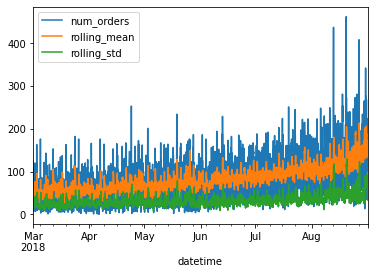

In [8]:
df.plot()

Теперь просмотрим разность рядов

<AxesSubplot:xlabel='datetime'>

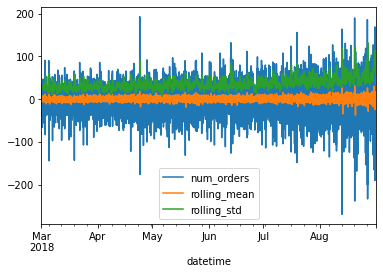

In [9]:
df_1 = df - df.shift()
df_1['rolling_mean'] = df_1['num_orders'].shift().rolling(10).mean()
df_1['rolling_std'] = df_1['num_orders'].rolling(10).std()
df_1.plot()

Графически можем определить что наш график стационарный

Подготовим функцию для последующих графиков:

In [10]:
def plot_graph(data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data, color='blue', label='Данные')
    plt.title(title)
    plt.xlabel('Данные')
    plt.ylabel('Значения')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Просмотрим графики тренда, сезонности, остатков декомпозиции

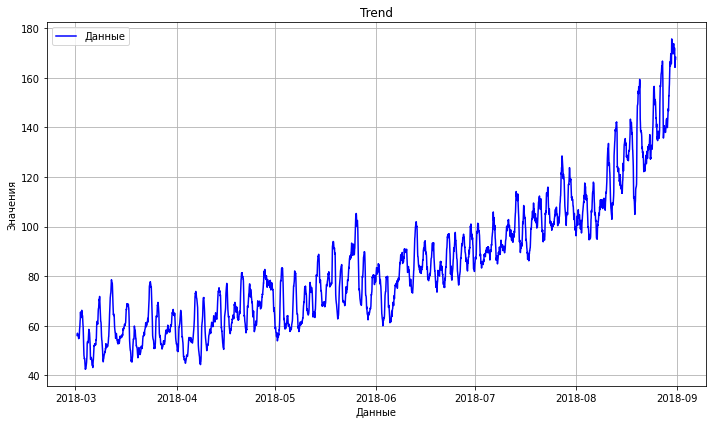

None

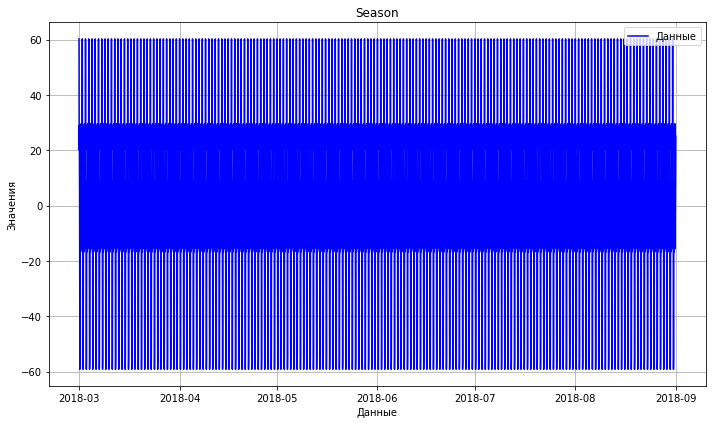

None

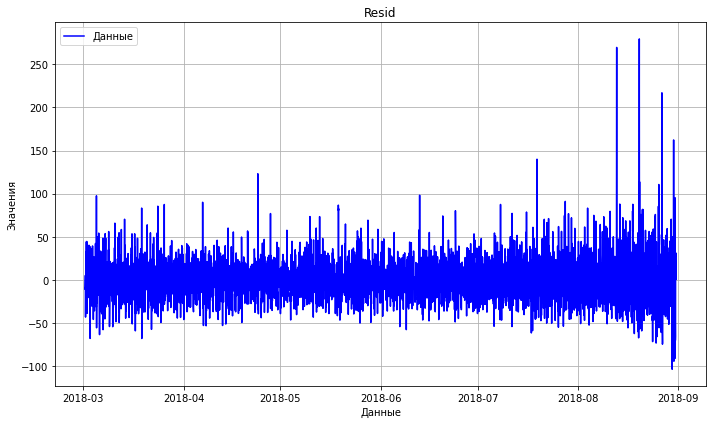

None

In [11]:
display(plot_graph(decomposing.trend,'Trend'))
display(plot_graph(decomposing.seasonal,'Season'))
display(plot_graph(decomposing.resid,'Resid'))

Рассмотрим сезонность на конкретном промежутке

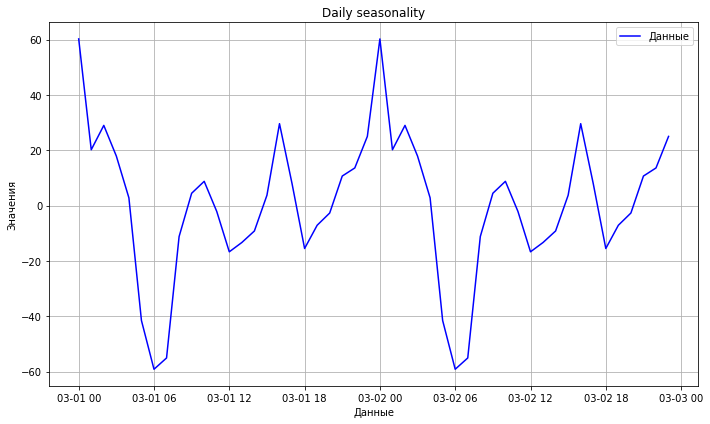

None

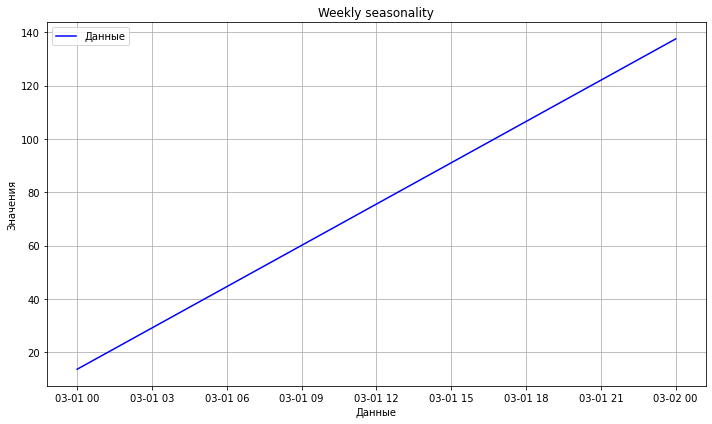

None

In [12]:
display(plot_graph(decomposing.seasonal['2018-03-01':'2018-03-2'], 'Daily seasonality'))
display(plot_graph(decomposing_day.seasonal['2018-03-01':'2018-03-2'], 'Weekly seasonality'))

### **Вывод по анализу данных:**
Выявлена сезонность по дням: заказы достигают минимума в ночное время, затем увеличиваются с утра и в течение дня, достигая максимума к вечеру. Это может указывать на влияние времени суток и потребительского поведения на объем заказов.
Наблюдается общий тренд устойчивого роста количества заказов, с периодическими небольшими снижениями. Это может свидетельствовать о постепенном увеличении спроса или о развитии бизнеса в данной сфере.


**Подготовка данных**

Подготовим функцию, которая позволит нам добавить признаки в таблицу

In [13]:
def make_features(data):
    data = df.copy()
    data['month'] = df.index.month
    data['day'] = df.index.day
    data['dayofweek'] = df.index.dayofweek
    data['hour'] = df.index.hour
    
    for i in range(1, 6):
        data['lag_{}'.format(i)] = data['num_orders'].shift(i)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(1).mean()
    data.dropna(inplace=True)
    
    return data
data = make_features(df)
data.head()

,num_orders,rolling_mean,rolling_std,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5
datetime,,,,,,,,,,,,
2018-03-01 09:00:00,69,34.0,37.426224,3,1,3,9,34.0,15.0,12.0,6.0,43.0
2018-03-01 10:00:00,64,69.0,28.414589,3,1,3,10,69.0,34.0,15.0,12.0,6.0
2018-03-01 11:00:00,96,64.0,30.225817,3,1,3,11,64.0,69.0,34.0,15.0,12.0
2018-03-01 12:00:00,30,96.0,29.470324,3,1,3,12,96.0,64.0,69.0,34.0,15.0
2018-03-01 13:00:00,32,30.0,28.532438,3,1,3,13,30.0,96.0,64.0,69.0,34.0


Теперь определим целевой признак и остальные

In [14]:
train,test = train_test_split(data,shuffle = False, random_state = 42, test_size = 0.1)
valid,test = train_test_split(test,shuffle = False, random_state = 42, test_size = 0.5)

In [15]:
train = train.dropna()
(train_features,
valid_features,
test_features) = (train.drop('num_orders',axis = 1),
                  valid.drop('num_orders',axis = 1),
                  test.drop('num_orders',axis = 1))
(train_target,
valid_target,
test_target) = (train['num_orders'],
                valid['num_orders'],
                test['num_orders'])

In [16]:
tscv = TimeSeriesSplit(n_splits=5)

Теперь данные готовы для обучения моделей

## Обучение

Перед обучением разных моделей, хотелось бы сказать, что критерии лучшей модели будем смотреть по 3 критериям: качество предсказания, скорость предсказания, время обучения.
В качестве метрики будем использовать RMSE

Рассмотрим первую модель: DecisionTreeRegressor

In [17]:
# Обучение модели
start_train = time.time()
DT = DecisionTreeRegressor(criterion='mse', random_state=42)
DT.fit(train_features,train_target)
end_train = time.time()
print(f"Время обучения: {end_train - start_train:.4f} сек")
# Предсказание на валидационных данных
start_pred = time.time()
valid_preds = DT.predict(valid_features)
end_pred = time.time()
print(f"Время предсказания: {end_pred - start_pred:.6f} сек")
# Расчёт RMSE на валидации
rmse_dt = np.sqrt(mean_squared_error(valid_target, valid_preds))
print("Decision Tree RMSE (на валидации):", rmse_dt)

Время обучения: 0.0348 сек
Время предсказания: 0.002533 сек
Decision Tree RMSE (на валидации): 47.42841495827734


Теперь LightGBM

In [18]:
lgb_train = lgb.Dataset(train_features,train_target)
lgb_valid = lgb.Dataset(valid_features,valid_target, reference=lgb_train)
parameters_light = {
    'metric': 'l2',
    'max_depth': 10,
    'random_state': RANDOM_STATE,
    'learning_rate': 0.1,
    'force_row_wise': True,
    'num_leaves': 5
}

# Измерение времени обучения
start_train = time.time()
light = lgb.train(
    parameters_light,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_valid]
)
end_train = time.time()
print(f"Время обучения: {end_train - start_train:.4f} сек")
# Измерение времени предсказания
start_pred = time.time()
valid_preds = light.predict(valid_features, num_iteration=light.best_iteration)
end_pred = time.time()
print(f"Время предсказания: {end_pred - start_pred:.6f} сек")
# Оценка качества модели
rmse = np.sqrt(mean_squared_error(valid_target, valid_preds))
print("LightGBM RMSE (на валидации):", rmse)

[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 3966, number of used features: 11
[LightGBM] [Info] Start training from score 78.359304
[1]	training's l2: 1385.1	valid_1's l2: 5270.68
[2]	training's l2: 1293.97	valid_1's l2: 4932.51
[3]	training's l2: 1219.78	valid_1's l2: 4760.21
[4]	training's l2: 1154.58	valid_1's l2: 4579.03
[5]	training's l2: 1102.51	valid_1's l2: 4446.06
[6]	training's l2: 1042.6	valid_1's l2: 4235.24
[7]	training's l2: 1005.8	valid_1's l2: 4127.26
[8]	training's l2: 958.937	valid_1's l2: 3947.82
[9]	training's l2: 919.664	valid_1's l2: 3793.82
[10]	training's l2: 893.529	valid_1's l2: 3604.82
[11]	training's l2: 866.707	valid_1's l2: 3479.14
[12]	training's l2: 837.495	valid_1's l2: 3357.9
[13]	training's l2: 815.117	valid_1's l2: 3249.99
[14]	training's l2: 793.372	valid_1's l2: 3155.23
[15]	training's l2: 772.532	valid_1's l2: 3092.2
[16]	training's l2: 750.796	valid_1's l2: 2965.27
[17]	training's l2: 734.26	valid_1

Теперь модель CatBoost

In [20]:
train_pool = Pool(train_features,train_target)
valid_pool = Pool(valid_features,valid_target)

# Определение модели и параметров для поиска
catboost = CatBoostRegressor(loss_function='RMSE', verbose=0)
parameters_cat = {
    'depth': [5, 10],
    'learning_rate': np.arange(0.1, 1, 0.2),
    'iterations': [50, 100] 
}
# Поиск по сетке (с использованием кросс-валидации на обучающей части)
catboost_grid = catboost.grid_search(parameters_cat, train_pool, cv=tscv, verbose=True, plot=False)
print("Лучшие параметры: ", catboost_grid['params'])
# Обучение модели с лучшими параметрами на тренировочной части
start_train = time.time()
best_model_cat = CatBoostRegressor(**catboost_grid['params'], loss_function='RMSE', verbose=0)
best_model_cat.fit(train_pool)
end_train = time.time()
print(f"Время обучения: {end_train - start_train:.4f} сек")
# Предсказание на валидации
start_pred = time.time()
valid_preds = best_model_cat.predict(valid_pool)
end_pred = time.time()
print(f"Время предсказания: {end_pred - start_pred:.6f} сек")
# RMSE на валидации
rmse_cat = np.sqrt(mean_squared_error(valid_target, valid_preds))
print("CatBoost RMSE (на валидации):", rmse_cat)


bestTest = 35.71779101
bestIteration = 49

0:	loss: 35.7177910	best: 35.7177910 (0)	total: 719ms	remaining: 13.7s

bestTest = 31.23892547
bestIteration = 44

1:	loss: 31.2389255	best: 31.2389255 (1)	total: 795ms	remaining: 7.15s

bestTest = 31.3072912
bestIteration = 43

2:	loss: 31.3072912	best: 31.2389255 (1)	total: 872ms	remaining: 4.94s

bestTest = 33.9194568
bestIteration = 48

3:	loss: 33.9194568	best: 31.2389255 (1)	total: 949ms	remaining: 3.79s

bestTest = 32.56205015
bestIteration = 48

4:	loss: 32.5620501	best: 31.2389255 (1)	total: 1.02s	remaining: 3.07s

bestTest = 32.74659465
bestIteration = 98

5:	loss: 32.7465946	best: 31.2389255 (1)	total: 1.17s	remaining: 2.73s

bestTest = 30.34847579
bestIteration = 84

6:	loss: 30.3484758	best: 30.3484758 (6)	total: 1.32s	remaining: 2.45s

bestTest = 31.24937618
bestIteration = 56

7:	loss: 31.2493762	best: 30.3484758 (6)	total: 1.47s	remaining: 2.2s

bestTest = 33.9194568
bestIteration = 48

8:	loss: 33.9194568	best: 30.3484758 (6)

И наконец модель RandomForestRegressor

In [21]:
# Определяем модель
RF = RandomForestRegressor(random_state=RANDOM_STATE)

# Определяем сетку гиперпараметров для настройки
parametrs = {
    "max_depth": [1, 10],
    "n_estimators": [100, 200]
}
# Настройка GridSearchCV
RF_grid = GridSearchCV(RF, parametrs, cv=tscv, verbose=True, n_jobs=-1)

# Обучение модели
start_train = time.time()
RF_grid.fit(train_features, train_target)
end_train = time.time()
print(f"Время обучения: {end_train - start_train:.4f} сек")

# Получение лучших параметров
best_params = RF_grid.best_params_
print(f"Лучшие параметры: {best_params}")

# Предсказание на валидационных данных
start_pred = time.time()
valid_preds = RF_grid.predict(valid_features)
end_pred = time.time()
print(f"Время предсказания: {end_pred - start_pred:.6f} сек")

# Расчёт RMSE на валидации
rmse_rf = np.sqrt(mean_squared_error(valid_target, valid_preds))
print("Random Forest RMSE (на валидации):", rmse_rf)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Время обучения: 17.8123 сек
Лучшие параметры: {'max_depth': 10, 'n_estimators': 200}
Время предсказания: 0.021410 сек
Random Forest RMSE (на валидации): 34.6181337276804


### **Вывод по обучению моделей:**
* Модель DesicionTreeRegressor
    * Время обучения: 0.0348 сек
    * Время предсказания: 0.002533 сек
    * Decision Tree RMSE (на валидации): 47.42841495827734
* Модель RandomForestRegressor
    * Время обучения: 17.8123 сек
    * Время предсказания: 0.021410 сек
    * Random Forest RMSE (на валидации): 34.6181337276804
* Модель LightGBM
    * Время обучения: 672.3152 сек
    * Время предсказания: 0.012046 сек
    * LightGBM RMSE (на валидации): 35.93039240338093
* Модель CatBoost
    * Время обучения: 0.7326 сек
    * Время предсказания: 0.000709 сек
    * CatBoost RMSE (на валидации): 33.71696385466271
* Лучшей моделью по метрике оказалась CatBoost - 33.7, при этом на 2 и 3 месте расположились RandomForestRegressor и LightGBM: 34.6, 35.9 соответственно.
Также стоит учесть, что время обучения RandomForestRegressor в 600 раз больше обучения других моделей.
Учитывая, наши приоритеты в модели, выберем CatBoost для будущего тестирования.

## Тестирование

Протестируем лучшую модель:

In [22]:
test_preds = best_model_cat.predict(test_features)
final_rmse = np.sqrt(mean_squared_error(test_target, test_preds))
print("LightGBM RMSE (на тесте):", final_rmse)

LightGBM RMSE (на тесте): 53.08882396490116


Так как по условию значение RMSE должно быть меньше, выберем другую модель для тестовых данных. В сравнении между LightGBM и ForestRegressor, выберем первую, так как время на обучение второй слишком большое, а разница метрик между этими моделями мала

In [23]:
test_preds = light.predict(test_features)
final_rmse = np.sqrt(mean_squared_error(test_target, test_preds))
print("LightGBM RMSE (на тесте):", final_rmse)

LightGBM RMSE (на тесте): 46.629339860859226


Отлично, значение метрики удовлетворяет условиям, модель выбрана!

## Вывод

**В ходе проекта были выполнены следующие шаги:**
* Подготовка данных
    - Загрузили данные,
    - Просмотрели общую информацию
        - Таблица состоит из 26496 строк и 1 столбца
        - Пропуски отсутствуют
        - Индексы отсортированы и проверенны на монотонность
        - На первый взгляд с данными в столбце num_orders все в порядке, отрицательные значения отсутствуют
    - Ресемплировали данные по часу
    - Подготовили разложение временного ряда на тренд, сезонность и остаток
    - Данные готовы к анализу
* Проанализировали данные
    - Выявлена сезонность по дням: заказы достигают минимума в ночное время, затем увеличиваются с утра и в течение дня, достигая максимума к вечеру. Это может указывать на влияние времени суток и потребительского поведения на объем заказов. Наблюдается общий тренд устойчивого роста количества заказов, с периодическими небольшими снижениями. Это может свидетельствовать о постепенном увеличении спроса или о развитии бизнеса в данной сфере.
* Обучили модели
    * Модель DesicionTreeRegressor
        * Время обучения: 0.0348 сек
        * Время предсказания: 0.002533 сек
        * Decision Tree RMSE (на валидации): 47.42841495827734
    * Модель RandomForestRegressor
        * Время обучения: 17.8123 сек
        * Время предсказания: 0.021410 сек
        * Random Forest RMSE (на валидации): 34.6181337276804
    * Модель LightGBM
        * Время обучения: 672.3152 сек
        * Время предсказания: 0.012046 сек
        * LightGBM RMSE (на валидации): 35.93039240338093
    * Модель CatBoost
        * Время обучения: 0.7326 сек
        * Время предсказания: 0.000709 сек
        * CatBoost RMSE (на валидации): 33.71696385466271
    * Лучшей моделью по метрике оказалась CatBoost - 33.7, при этом на 2 и 3 месте расположились RandomForestRegressor и LightGBM: 34.6, 35.9 соответственно.
* Протестировали лучшую модель, которая оказалась lightGBM со значением метрики RMSE 46.6, что удовлетворяет условиям